# Import libraries

In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import random
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Load API
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam

# Loading and Visualizing the dataset

### File 'u.data'

In [3]:
r_cols = ['user_id', 'item_id', 'rating', 'timestamp']
df_1 = pd.read_csv('u.data',  sep='\t', names=r_cols, encoding='latin-1')

# creating a new copy so that any changes to original data 'u.item' will not affect the train and test set below
df_ratings = df_1.copy()

df_ratings[['user_id', 'item_id', 'rating']] = df_ratings[['user_id', 'item_id', 'rating']].astype(dtype = 'int64')

# sort by timestamp for splitting into training and testing data set later
df_ratings = df_ratings.sort_values(by = 'timestamp')

In [6]:
num_movies1 = df_ratings['item_id'].nunique()
num_users1 = df_ratings['user_id'].nunique()

print("Number of movies: ", num_movies1)
print("Number of users: ", num_users1)

Number of movies:  1682
Number of users:  943


In [4]:
print("Minimum number of ratings by user: ", min(df_1['user_id'].value_counts()))
print("Maximum number of ratings by user: ", max(df_1['user_id'].value_counts()))

Minimum number of ratings by user:  20
Maximum number of ratings by user:  737


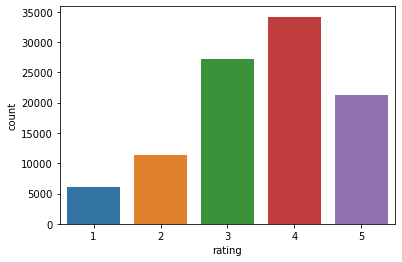

In [77]:
sns.countplot(data=df_ratings, x='rating')

In [73]:
df_ratings['item_id'].value_counts().head()

50     583
258    509
100    508
181    507
294    485
Name: item_id, dtype: int64

In [79]:
df_ratings['item_id'].value_counts().tail()

1648    1
1571    1
1329    1
1457    1
1663    1
Name: item_id, dtype: int64

In [94]:
pd.pivot_table(data=df_ratings, index='user_id', columns='item_id', values='rating').notnull().mean()

item_id
1       0.479321
2       0.138918
3       0.095440
4       0.221633
5       0.091198
          ...   
1678    0.001060
1679    0.001060
1680    0.001060
1681    0.001060
1682    0.001060
Length: 1682, dtype: float64

### File 'u.item'

In [7]:
m_cols = ['item_id', 'movie_title', 'release_date', 'video_release_date', 'URL', 'unknown',
          'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary',
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

df_2 = pd.read_csv('u.item',  sep='|', names=m_cols, encoding='latin-1')


# creating a new copy so that any changes to original data 'u.item' will not affect the train and test set below
df_movieinfo = df_2[['item_id', 'movie_title']].copy()

### File 'u.user'

In [8]:
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip code']
df_3 = pd.read_csv('u.user',  sep='|', names=u_cols, encoding='latin-1')

# Splitting the datasets

Split the ratings dataset in such a way that 70% of each user’s rating
scores is in the training dataset and 30% is in the testing dataset. Split them in a way that the
**most recent ratings** are included in the testing dataset

In [9]:
%%time
movieTrain = pd.DataFrame(columns = df_ratings.columns.tolist())
movieTest = pd.DataFrame(columns = df_ratings.columns.tolist())


for i in set(list(df_ratings['user_id'])):
    sub_df = df_ratings[df_ratings['user_id'] == i]
    len_df = len(sub_df)
    movieTrain = movieTrain.append([sub_df.head(round(len_df*0.7))])
    movieTest = movieTest.append([sub_df.tail(len_df - round(len_df*0.7))])

Wall time: 8.1 s


In [10]:
movieTrain = movieTrain.astype('int64')
movieTest = movieTest.astype('int64')

In [11]:
print(type(movieTrain))
print(movieTrain.shape, movieTest.shape)

<class 'pandas.core.frame.DataFrame'>
(70003, 4) (29997, 4)


### Create a Training User-Movie Matrix
#### Rows are user, columns are movies

In [12]:
# Converting dataframe into numpy arrays to be fed into autoencoder later
usermovie_matrix_train = np.zeros((num_users1, num_movies1))

for (idx, row) in movieTrain.iterrows():
    user_id = row[0]
    movie_id = row[1]
    ratings = row[2]
    usermovie_matrix_train[user_id-1, movie_id-1] = ratings

In [13]:
usermovie_matrix_train.shape

(943, 1682)

### Create a Testing User-Movie Matrix
#### Rows are user, columns are movies

In [14]:
# Converting dataframe into numpy arrays to be fed into autoencoder later
usermovie_matrix_test = np.zeros((num_users1, num_movies1))

for (idx, row) in movieTest.iterrows():
    user_id = row[0]
    movie_id = row[1]
    ratings = row[2]
    usermovie_matrix_test[user_id-1, movie_id-1] = ratings

In [15]:
usermovie_matrix_test.shape

(943, 1682)

<br>

# Question 1 - Simple Autoencoder
Build a simple version of the Autoencoder with only one hidden
layer in such a way that it reconstructs the inputs of the users’ rating rows in the train set.
Then, try to input users’ rating rows in test set and see how much the model reconstruct
original inputs correctly. What is the RMSE score obtained by this model?

In [16]:
# define hyperparameters
encoding_dim = 20
batch_size = 64
learning_rate = 0.001

# stop training the model when the validation loss does not decrease
# restore model weights from the epoch with the best value of the monitored metric
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [17]:
# build simple autoencoder model

# this is our input placeholder
input_ratings = Input(shape=(1682,))

# encoded representation of the input
encoded = Dense(encoding_dim, activation='sigmoid')(input_ratings)

# reconstruction of the input
decoded = Dense(1682)(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_ratings, decoded)

In [18]:
# show model info
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1682)]            0         
_________________________________________________________________
dense (Dense)                (None, 20)                33660     
_________________________________________________________________
dense_1 (Dense)              (None, 1682)              35322     
Total params: 68,982
Trainable params: 68,982
Non-trainable params: 0
_________________________________________________________________


In [19]:
# create a custom loss function
# to consider the output values that correspond to the indices of the non-zero values in the input set

def custom_loss_function(y_true, y_pred):
    mask = (y_true == 0)
    y_pred = tf.where(mask, y_true, y_pred)
    mse_masked = K.mean(K.square(y_true - y_pred), axis=-1)
    return mse_masked

In [20]:
# set train methodology
optimizer = Adam(learning_rate=learning_rate)

autoencoder.compile(loss=custom_loss_function, optimizer=optimizer, metrics=custom_loss_function)

In [21]:
autoencoder.fit(usermovie_matrix_train, usermovie_matrix_train, batch_size=batch_size, epochs=300,
                    verbose=0, validation_data=(usermovie_matrix_test, usermovie_matrix_test), callbacks=early_stop)

#### Test the trained model

In [22]:
decoded_ratings = autoencoder.predict(usermovie_matrix_test)

In [23]:
mask_rate = usermovie_matrix_test > 0
test_loss = sqrt(np.mean((usermovie_matrix_test[mask_rate] - decoded_ratings[mask_rate])**2))
print("Using Simple Autoencoder: ")
print("Test loss (RMSE): ", test_loss)

Using Simple Autoencoder: 
Test loss (RMSE):  1.0932526018851814


<br>

<br>

# Question 2 - Stacked Autoencoder
Try to expand the previous version of the autoencoder model.
You can consider applying other deep learning techniques (Hint: adding more layers,
avoiding overfitting technique (Dropout, Batch Normalization, etc.)). Then, try to do the
same evaluation as done in Q1. What is the RMSE score obtained by this model?

In [24]:
encoding_dim1 = 20
encoding_dim2 = 10
decoding_dim1 = 20

In [25]:
# build stacked autoencoder model

# this is our input placeholder
input_ratings = Input(shape=(1682,))

# 1st encoding layer + batch normalization + drop out
encoded1 = Dense(encoding_dim1, activation='sigmoid')(input_ratings)
encoded1 = Dropout(0.2)(encoded1)

# 2nd encoding layer
encoded2 = Dense(encoding_dim2, activation='sigmoid')(encoded1)
encoded2 = Dropout(0.2)(encoded2)

# 1st decoding layer
decoded1 = Dense(decoding_dim1, activation='sigmoid')(encoded2)

# 2nd decoding layer
decoded2 = Dense(1682)(decoded1)

# this model maps an input to its reconstruction
autoencoder2 = Model(input_ratings, decoded2)

In [26]:
# show model info
autoencoder2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1682)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                33660     
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_5 (Dense)              (None, 1682)             

In [27]:
# set train methodology
optimizer = Adam(learning_rate=learning_rate)

autoencoder2.compile(loss=custom_loss_function, optimizer=optimizer, metrics=custom_loss_function)

In [28]:
autoencoder2.fit(usermovie_matrix_train, usermovie_matrix_train, batch_size=batch_size, epochs=300,
                    verbose=0, validation_data=(usermovie_matrix_test, usermovie_matrix_test), callbacks=early_stop)

#### Test the trainined model

In [29]:
decoded_ratings2 = autoencoder2.predict(usermovie_matrix_test)

In [30]:
mask_rate = usermovie_matrix_test > 0
test_loss2 = sqrt(np.mean((usermovie_matrix_test[mask_rate] - decoded_ratings2[mask_rate])**2))
print("Using Stacked Autoencoder: ")
print("Test loss (RMSE): ", test_loss2)

Using Stacked Autoencoder: 
Test loss (RMSE):  1.079540010171092


<br>

<br>

# Question 3 - Build User Profile Vectors (Auxiliary Information)

Build user profile vectors as auxiliary information by using ‘u.user’ file by yourself. <br>
Show your vector’s definition into a table form. (Hint: Consider
changing the categorical variables into one-hot encoding.)

In [95]:
# check if u.user file contains all the User ID in u.data file
sum(~df_3['user_id'].isin(df_ratings['user_id'].unique()))

0

In [32]:
user_profile = df_3.copy().drop(columns='zip code')

In [33]:
user_profile.head(3)

,user_id,age,gender,occupation
0,1,24,M,technician
1,2,53,F,other
2,3,23,M,writer


#### One-hot encoding for OCCUPATION

In [34]:
occupation = user_profile.pop('occupation')

for i in occupation.unique():
    user_profile[i] = (occupation == i)*1.0

#### One-hot encoding for GENDER

In [35]:
gender = user_profile.pop('gender')

user_profile['male'] = (gender == 'M')*1.0
user_profile['female'] = (gender == 'F')*1.0

#### Scaling AGE

In [36]:
# scale the age from 0 to 5, same as rating scale
user_profile['scaled_age'] = user_profile['age'] / 20

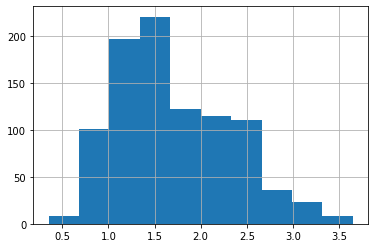

In [37]:
user_profile['scaled_age'].hist()

#### Converting to vector to be concatenated with ratings matrix later

In [38]:
user_profile = user_profile.sort_values(by='user_id')
user_profile_v = user_profile.drop(columns=['user_id', 'scaled_age']).to_numpy()
user_profile_v.shape

(943, 24)

In [39]:
user_profile_v2 = user_profile.drop(columns=['user_id', 'age']).to_numpy()
user_profile_v2.shape

(943, 24)

<br>

# Question 4 - Combining Auxiliary Information into Autoencoder
#### Expand your Deep Autoencoder model to utilize user profile vectors
(Hint: Simple concatenation of a user profile vector with a user rating’s row is one of the combination approaches). <br>
Then, try to do the same evaluation in Q1. What is the RMSE score obtained by your proposed model?

#### User profile vector with NON-scaled age

In [40]:
usermovieaux_matrix_train = np.concatenate((usermovie_matrix_train, user_profile_v), axis=1)
usermovieaux_matrix_train.shape

(943, 1706)

In [41]:
usermovieaux_matrix_test = np.concatenate((usermovie_matrix_test, user_profile_v), axis=1)
usermovieaux_matrix_test.shape

(943, 1706)

#### User profile vector with scaled age

In [42]:
usermovieaux_matrix_train_s = np.concatenate((usermovie_matrix_train, user_profile_v2), axis=1)
usermovieaux_matrix_train_s.shape

(943, 1706)

In [43]:
usermovieaux_matrix_test_s = np.concatenate((usermovie_matrix_test, user_profile_v2), axis=1)
usermovieaux_matrix_test_s.shape

(943, 1706)

#### Using SAME Stacked Autoencoder Layers from Question 2 (with different custom loss function)

In [44]:
# create a custom loss function
# to consider the output values that correspond to the indices of the non-zero ratings in the input set
# to also ignore the predictions of user profile vector

def custom_loss_function1(y_true, y_pred):
    mask = (y_true == 0)
    y_pred = tf.where(mask, y_true, y_pred)
    mse_masked = K.mean(K.square(y_true[:, :1682] - y_pred[:, :1682]), axis=-1)
    return mse_masked

In [45]:
encoding_dim1 = 20
encoding_dim2 = 10
decoding_dim1 = 20

In [46]:
# build stacked autoencoder model

# this is our input placeholder
input_ratings = Input(shape=(1706,))

# 1st encoding layer
encoded1 = Dense(encoding_dim1, activation='sigmoid')(input_ratings)
encoded1 = Dropout(0.2)(encoded1)

# 2nd encoding layer
encoded2 = Dense(encoding_dim2, activation='sigmoid')(encoded1)
encoded2 = Dropout(0.2)(encoded2)

# 1st decoding layer
decoded1 = Dense(decoding_dim1, activation='sigmoid')(encoded2)

# 2nd decoding layer
decoded2 = Dense(1706)(decoded1)

# this model maps an input to its reconstruction
autoencoder3 = Model(input_ratings, decoded2)

In [47]:
# show model info
autoencoder3.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1706)]            0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                34140     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_9 (Dense)              (None, 1706)             

In [48]:
# set train methodology
optimizer = Adam(learning_rate=learning_rate)

autoencoder3.compile(loss=custom_loss_function1, optimizer=optimizer, metrics=custom_loss_function1)

### Training with non-scaled age

In [49]:
autoencoder3.fit(usermovieaux_matrix_train, usermovieaux_matrix_train, batch_size=batch_size, epochs=300,
                    verbose=0, validation_data=(usermovieaux_matrix_test, usermovieaux_matrix_test), callbacks=early_stop)

#### Testing the trained model (without scaled age)

In [50]:
decoded_ratings3 = autoencoder3.predict(usermovieaux_matrix_test)

In [51]:
mask_rate_user_profile = usermovieaux_matrix_test[:, :1682] > 0
test_loss3 = sqrt(np.mean((usermovieaux_matrix_test[:, :1682][mask_rate_user_profile]
                          - decoded_ratings3[:, :1682][mask_rate_user_profile])**2))
print("Using Stacked Autoencoder with User Profile Vector (non-scaled original data): ")
print("Test loss (RMSE): ", test_loss3)

Using Stacked Autoencoder with User Profile Vector (non-scaled original data): 
Test loss (RMSE):  1.0792691976498234


### Training with age scaled between 0~5

In [52]:
input_ratings = Input(shape=(1706,))

# 1st encoding layer
encoded1 = Dense(encoding_dim1, activation='sigmoid')(input_ratings)
encoded1 = Dropout(0.2)(encoded1)

# 2nd encoding layer
encoded2 = Dense(encoding_dim2, activation='sigmoid')(encoded1)
encoded2 = Dropout(0.2)(encoded2)

# 1st decoding layer
decoded1 = Dense(decoding_dim1, activation='sigmoid')(encoded2)

# 2nd decoding layer
decoded2 = Dense(1706)(decoded1)

# this model maps an input to its reconstruction
autoencoder3_s = Model(input_ratings, decoded2)

In [53]:
autoencoder3_s.compile(loss=custom_loss_function1, optimizer=optimizer, metrics=custom_loss_function1)

In [54]:
autoencoder3_s.fit(usermovieaux_matrix_train_s, usermovieaux_matrix_train_s, batch_size=batch_size, epochs=300,
                    verbose=0, validation_data=(usermovieaux_matrix_test_s, usermovieaux_matrix_test_s), callbacks=early_stop)

#### Testing the trained model (with scaled age)

In [55]:
decoded_ratings3_s = autoencoder3_s.predict(usermovieaux_matrix_test_s)

In [56]:
mask_rate_user_profile = usermovieaux_matrix_test_s[:, :1682] > 0
test_loss3_s = sqrt(np.mean((usermovieaux_matrix_test_s[:, :1682][mask_rate_user_profile]
                          - decoded_ratings3_s[:, :1682][mask_rate_user_profile])**2))
print("Using Stacked Autoencoder with User Profile Vector (with scaled age): ")
print("Test loss (RMSE): ", test_loss3_s)

Using Stacked Autoencoder with User Profile Vector (with scaled age): 
Test loss (RMSE):  1.0797127852614685


<br>

<br>

# Question 5 - Cold Start Problem
Build a **cold-start prediction model** in such a way
that it returns top 10 movies (movie ID, movie title, predicted rating score, actual rating
score) from the testing dataset. <br><br> Data generation for this cold-start prediction is as follows: <br>
Pick five users who show **low sparsity** and fill 50% movie rating scores to zeroes randomly.
Reconstruct those scores using the autoencoder model in Q4, and track how much those
reconstructed (predicted) scores match the original rating scores. Sort movie recommendation
results based on the predicted rating score. Do this for 5 users and report the recommendation
results.

In [57]:
# get user ID of 5 users with the greatest number of ratings in the testing set
top5user = movieTest['user_id'].value_counts().head().sort_index().index.tolist()
print("5 User IDs with low sparsity: ", top5user)

5 User IDs with low sparsity:  [13, 276, 405, 450, 655]


In [58]:
top5user_df = pd.DataFrame(columns=['user_id', 'item_id', 'rating'])

# lists of index to be used for comparison later
rand_idx_list = [] 

for i in top5user:
    rating_set = movieTest[movieTest['user_id'] == i].reset_index()
    idx_set = rating_set['index'].tolist()
    
    # number of actual ratings made
    length = len(idx_set)
    
    # sample half of the indexes randomly
    rand_idx = random.sample(idx_set, round(length/2))
    rand_idx_list.append(rand_idx)
    
    # set the ratings of randomly selected index to zero
    rating_set.loc[(rating_set['user_id'] == i) & (rating_set['index'].isin(rand_idx)), 'rating'] = 0
    rating_set = rating_set.drop(columns=['index','timestamp'])
    top5user_df = top5user_df.append(rating_set)

In [59]:
# adding rank for indexing later
top5user_df['user_rank'] = top5user_df['user_id'].rank(method='dense').astype('int64')
top5user_df.shape

(935, 4)

In [60]:
top5_matrix_test = np.zeros((5, num_movies1))

for (idx, row) in top5user_df.iterrows():
    rank = row[3]
    movie_id = row[1]
    ratings = row[2]
    top5_matrix_test[rank-1, movie_id-1] = ratings

In [61]:
top5user_profile = user_profile[user_profile['user_id'].isin(top5user)].sort_values(by='user_id')

# since the trained model using scaled age does not provide better results, we will use the model trained without the scaled age
top5user_profile_v = top5user_profile.drop(columns=['user_id', 'scaled_age']).to_numpy()
top5user_profile_v.shape

(5, 24)

In [62]:
# concatenate with the user profile vector
top5_matrix_test = np.concatenate((top5_matrix_test, top5user_profile_v), axis=1)
top5_matrix_test.shape

(5, 1706)

In [63]:
pred = pd.DataFrame(columns=['Movie ID', 'Predicted Rating', 'Actual Rating', 'User ID'])

print("Prediction using Stacked Autoencoder Model from Question 4: \n")

for i in range(5):
    # create a temporary df to be concatenated later
    temp = pd.DataFrame(columns=['Movie ID', 'Predicted Rating', 'Actual Rating'])
    temp['Movie ID'] = range(1, 1683)
    temp['User ID'] = top5user[i]
    temp['Actual Rating'] = top5_matrix_test[i][:1682]
    
    # predict using autoencoder model trained in Question 4
    prediction = autoencoder3.predict(top5_matrix_test[i].reshape(1,1706))
    temp['Predicted Rating'] = prediction.reshape(1706,)[:1682]
    
    
    # calculate the RMSE of the predictions
    mask_q5 = top5_matrix_test[i][:1682] > 0
    loss_q5 = sqrt(np.mean((top5_matrix_test[i][:1682][mask_q5]
                          - prediction.reshape(1706,)[:1682][mask_q5])**2))
    print("RMSE of User", top5user[i], "=", loss_q5, "\n")
    
    
    # remove rows without actual ratings
    temp = temp.drop(temp[temp['Actual Rating'] == 0].index)
    
    # concate to the big df
    pred = pd.concat([pred, temp])

Prediction using Stacked Autoencoder Model from Question 4: 

RMSE of User 13 = 1.2380497742549006 

RMSE of User 276 = 0.6674012894594479 

RMSE of User 405 = 1.9527475641173917 

RMSE of User 450 = 0.9913179065843128 

RMSE of User 655 = 1.2780234080163857 



In [64]:
# merge to get movie title
pred_info = pd.merge(pred, df_movieinfo, left_on='Movie ID', right_on='item_id', how='left')
pred_info = pred_info[['Movie ID', 'movie_title', 'Predicted Rating', 'Actual Rating', 'User ID']]
pred_info = pred_info.rename(columns={"movie_title": "Movie Title"})
pred_info

for i in top5user:
    temp1 = pred_info[pred_info['User ID'] == i].sort_values(by='Predicted Rating', ascending=False).head(10)
    print("Top 10 Movies for User", i, " (based on predicted ratings):")
    print(temp1.drop(columns='User ID'))
    print("\n=================================================================================")

Top 10 Movies for User 13  (based on predicted ratings):
   Movie ID                   Movie Title  Predicted Rating  Actual Rating
35      427  To Kill a Mockingbird (1962)          4.274357            5.0
14      313                Titanic (1997)          4.243368            4.0
17      316     As Good As It Gets (1997)          4.175982            5.0
41      488           Sunset Blvd. (1950)          4.130918            3.0
16      315              Apt Pupil (1998)          4.064805            5.0
0        14            Postino, Il (1994)          4.027975            4.0
50      694             Persuasion (1995)          3.999524            4.0
2        28              Apollo 13 (1995)          3.992649            5.0
12      269        Full Monty, The (1997)          3.975934            2.0
44      614                  Giant (1956)          3.935493            4.0

Top 10 Movies for User 276  (based on predicted ratings):
    Movie ID                                   Movie Title 

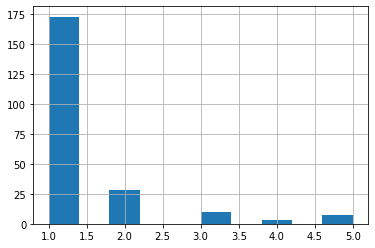

In [106]:
# prediction for user ID 405 is really bad!
# checking the ratings of User ID 405 in test set
movieTest.loc[movieTest['user_id']==405, 'rating'].hist()

In [109]:
movieTest.loc[movieTest['user_id']==405, 'rating'].value_counts().sort_index()

1    173
2     28
3     10
4      3
5      7
Name: rating, dtype: int64

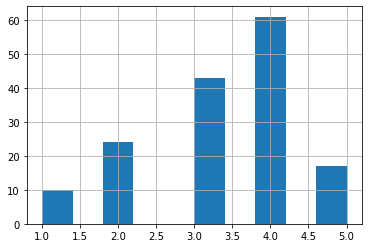

In [107]:
# prediction for user ID 276 is quite good!
# checking the ratings of User ID 276 in test set
movieTest.loc[movieTest['user_id']==276, 'rating'].hist()

In [110]:
movieTest.loc[movieTest['user_id']==276, 'rating'].value_counts().sort_index()

1    10
2    24
3    43
4    61
5    17
Name: rating, dtype: int64

In [146]:
listt = movieTest.loc[rand_idx_list[0], 'item_id'].tolist()

In [150]:
# rand_idx_list[0]
autoencoder3.predict(top5_matrix_test[0].reshape(1,1706)).flatten()

array([ 3.9137456 ,  3.2295823 ,  3.1250608 , ...,  0.00834726,
       -0.26461545, -0.03886619], dtype=float32)